<a href="https://colab.research.google.com/github/raz0208/Advance-Quantitative-Research-Project/blob/main/Task2/Natural_Gas_Storage_Contract_Pricing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Gas Storage Contract Pricing Prototype

In [52]:
# Import Required Libraries and Pakages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from datetime import date, timedelta
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

In [53]:
# Load and Read datasets

# Read raw dataset
Nat_Gas_df = pd.read_csv('Nat_Gas.csv')

# Check and convert data column to date format
Nat_Gas_df['Dates'] = pd.to_datetime(Nat_Gas_df['Dates'])
Nat_Gas_df = Nat_Gas_df.set_index('Dates')

print("Natural Gas Raw Dataset")
print(Nat_Gas_df.head(10))

# Read ETS forecasted price dataset
ETS_df = pd.read_csv('/content/ETS_Nat_Gas_Forcasted_Prices(Monthly).csv')
ETS_df['Dates'] = pd.to_datetime(ETS_df['Dates'])
ETS_df = ETS_df.set_index('Dates')

print("\nETS Forecast Dataset")
print(ETS_df.head(10))

Natural Gas Raw Dataset
            Prices
Dates             
2020-10-31   10.10
2020-11-30   10.30
2020-12-31   11.00
2021-01-31   10.90
2021-02-28   10.90
2021-03-31   10.90
2021-04-30   10.40
2021-05-31    9.84
2021-06-30   10.00
2021-07-31   10.10

ETS Forecast Dataset
               Prices
Dates                
2024-10-31  12.206504
2024-11-30  12.724507
2024-12-31  13.056321
2025-01-31  13.158380
2025-02-28  12.929262
2025-03-31  13.169657
2025-04-30  12.591878
2025-05-31  12.114226
2025-06-30  12.022451
2025-07-31  12.278492


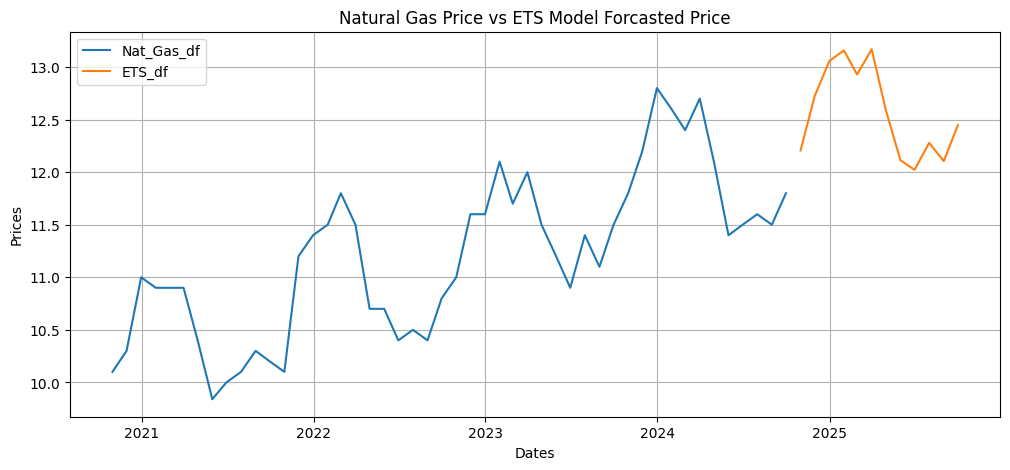

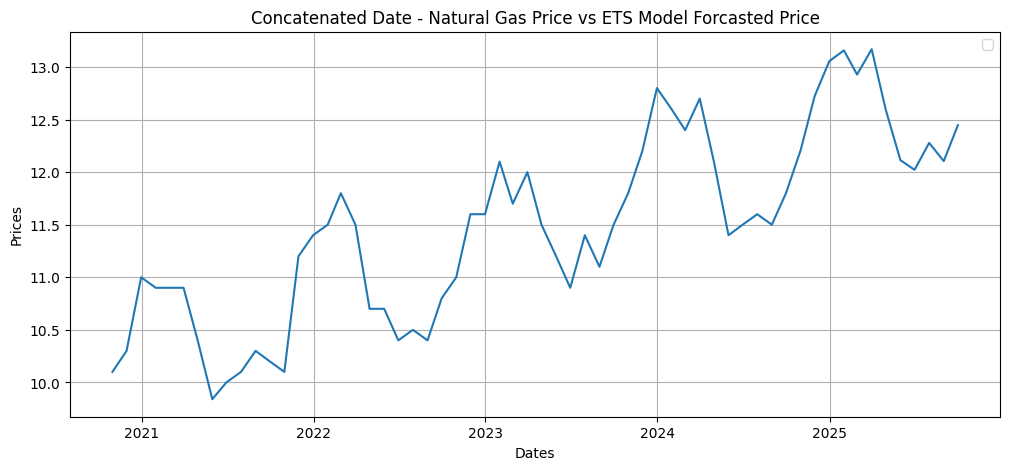

In [54]:
# Plot Nat_Gas_df and ETS_df
plt.figure(figsize=(12,5))
plt.plot(Nat_Gas_df.index, Nat_Gas_df['Prices'], label='Nat_Gas_df')
plt.plot(ETS_df.index, ETS_df['Prices'], label='ETS_df')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Natural Gas Price vs ETS Model Forcasted Price')
plt.legend()
plt.grid(True)
plt.show()
print("\n")


# Add the ETS_df forcasted data to end of the Nat_Gas_df dataset
concat_df = pd.concat([Nat_Gas_df, ETS_df], axis=0)
concat_df.head(10), concat_df.tail(10)

# Plot concat_df
plt.figure(figsize=(12, 5))
plt.plot(concat_df.index, concat_df['Prices'])
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Concatenated Date - Natural Gas Price vs ETS Model Forcasted Price')
plt.grid(True)
plt.legend()
plt.show()

In [55]:
### Daily Interpolation (Historical data)
# Create daily date range for historical period
hist_daily_index = pd.date_range(start=Nat_Gas_df.index.min(), end=Nat_Gas_df.index.max(), freq='D')

# Reindex and interpolate linearly
hist_daily_curve = (Nat_Gas_df.reindex(hist_daily_index).interpolate(method='linear'))
hist_daily_curve.index.name = 'Dates'


### Daily extrapolation (1 Year Forward Using ETS Model Forcasted Data)
# Create daily date range for forecast period
forecast_daily_index = pd.date_range(start=ETS_df.index.min(), end=ETS_df.index.max(), freq='D')

# Reindex ETS monthly prices to daily and interpolate
forecast_daily_curve = (ETS_df.reindex(forecast_daily_index).interpolate(method='linear'))
forecast_daily_curve.index.name = 'Dates'


# Combine into final daily forward curve
daily_forward_curve = pd.concat([hist_daily_curve, forecast_daily_curve])

# Remove duplicate dates (if overlap exists)
daily_forward_curve = daily_forward_curve[~daily_forward_curve.index.duplicated(keep='last')]

print("Daily Forward Curve")
print(daily_forward_curve.head(10))
print(daily_forward_curve.tail(10))


Daily Forward Curve
               Prices
Dates                
2020-10-31  10.100000
2020-11-01  10.106667
2020-11-02  10.113333
2020-11-03  10.120000
2020-11-04  10.126667
2020-11-05  10.133333
2020-11-06  10.140000
2020-11-07  10.146667
2020-11-08  10.153333
2020-11-09  10.160000
               Prices
Dates                
2025-09-21  12.344502
2025-09-22  12.355902
2025-09-23  12.367303
2025-09-24  12.378703
2025-09-25  12.390104
2025-09-26  12.401504
2025-09-27  12.412905
2025-09-28  12.424305
2025-09-29  12.435706
2025-09-30  12.447106


In [56]:
# Function to Calculate Natural Gas Price
def calculate_contract_value(
    injection_schedule, # List of tuples (date_str, volume). Volume can be a number or string.
    withdrawal_schedule, # List of tuples (date_str, volume). Volume can be a number or 'All'
    max_volume, # Maximum storage capacity.
    storage_cost_per_month, # Fixed monthly cost for storage.
    injection_withdrawal_cost_per_unit, # Variable cost per unit volume.
    transport_cost_per_trip, # Fixed cost per transport event.
    price_data #DataFrame with daily prices.
):

    """
    Calculates the value of a gas storage contract with variable rates per date.

    Returns:
    - contract_value: Total Net Present Value (assuming 0 interest).
    - details_df: DataFrame containing the schedule and cash flows.
    """

    # 1. Combine and standardize events
    events = []

    for date_str, vol in injection_schedule:
        events.append({
            'Date': pd.to_datetime(date_str),
            'Type': 'Injection',
            'Requested_Volume': vol
        })

    for date_str, vol in withdrawal_schedule:
        events.append({
            'Date': pd.to_datetime(date_str),
            'Type': 'Withdrawal',
            'Requested_Volume': vol
        })

    if not events:
        return 0, pd.DataFrame()

    # Sort by date
    schedule = pd.DataFrame(events).sort_values('Date').reset_index(drop=True)

    # 2. Iterate and Calculate
    inventory = 0
    results = []

    # Sort price data for efficient lookup
    price_data = price_data.sort_index()

    for i, row in schedule.iterrows():
        current_date = row['Date']
        action_type = row['Type']
        req_vol = row['Requested_Volume']

        # Get Price
        try:
            if current_date in price_data.index:
                price = price_data.loc[current_date, 'Prices']
            else:
                price = price_data.asof(current_date)['Prices']
        except KeyError:
            price = np.nan

        # Determine Actual Volume
        volume = 0

        if action_type == 'Injection':
            try:
                vol_float = float(req_vol)
            except ValueError:
                vol_float = 0 # Handle invalid input gracefully

            # Constraint: Max Storage
            space_available = max_volume - inventory
            volume = min(vol_float, space_available)
            volume = max(0, volume) # Ensure non-negative

            # Cash Flow: Outflow
            # Cost = (Price * Vol) + (InjRate * Vol) + Transport
            gas_cost = volume * price
            inj_cost = volume * injection_withdrawal_cost_per_unit
            trans_cost = transport_cost_per_trip

            cash_flow = -(gas_cost + inj_cost + trans_cost)
            inventory += volume

        elif action_type == 'Withdrawal':
            # Handle 'All'
            if isinstance(req_vol, str) and req_vol.lower() == 'all':
                volume = inventory
            else:
                try:
                    vol_float = float(req_vol)
                except ValueError:
                    vol_float = 0

                # Constraint: Min Storage (0)
                volume = min(vol_float, inventory)
                volume = max(0, volume)

            # Cash Flow: Inflow
            # Revenue = (Price * Vol) - (WithRate * Vol) - Transport
            gas_rev = volume * price
            with_cost = volume * injection_withdrawal_cost_per_unit
            trans_cost = transport_cost_per_trip

            cash_flow = gas_rev - with_cost - trans_cost
            inventory -= volume

        results.append({
            'Date': current_date,
            'Action': action_type,
            'Price': price,
            'Requested_Volume': req_vol,
            'Executed_Volume': volume,
            'Inventory': inventory,
            'Cash_Flow': cash_flow
        })

    details_df = pd.DataFrame(results)

    # 3. Calculate Storage Cost
    if not details_df.empty:
        start_date = details_df['Date'].min()
        end_date = details_df['Date'].max()
        duration_months = (end_date - start_date).days / 30.44
        if duration_months < 1: duration_months = 1
        total_storage_cost = duration_months * storage_cost_per_month
    else:
        total_storage_cost = 0

    contract_value = details_df['Cash_Flow'].sum() - total_storage_cost

    return contract_value, details_df

In [64]:
# Test Scenario Data

# Sample Strategy: Dates/Rates, Storage Capacity, Storage Cost Per Month etc.
inj_dates_rates = [('2024-10-28', '1000000'), ('2024-11-15', '800000'), ('2024-12-20', '900000')]
with_dates_rates = [('2025-01-15', '900000'), ('2025-02-15', '800000'), ('2025-03-15', 'All')]

max_vol = 2000000
storage_cost = 100000 # 100k/month
inj_with_cost = 0.01 # $10k per 1M -> 0.01 per 1
transport_cost = 50000 # 50k per trip


value, df_res = calculate_contract_value(
    inj_dates_rates, with_dates_rates,
    max_vol,
    storage_cost,
    inj_with_cost,
    transport_cost,
    daily_forward_curve
)

print(f"Contract Value: ${value:,.2f}")
print("\nDetails:")
print(df_res[['Date', 'Action', 'Price', 'Requested_Volume', 'Executed_Volume', 'Inventory', 'Cash_Flow']])



Contract Value: $983,848.10

Details:
        Date      Action      Price Requested_Volume  Executed_Volume  \
0 2024-10-28   Injection  11.800000          1000000        1000000.0   
1 2024-11-15   Injection  12.465505           800000         800000.0   
2 2024-12-20   Injection  12.938581           900000         200000.0   
3 2025-01-15  Withdrawal  13.105704           900000         900000.0   
4 2025-02-15  Withdrawal  13.035638           800000         800000.0   
5 2025-03-15  Withdrawal  13.045582              All         300000.0   

   Inventory     Cash_Flow  
0  1000000.0 -1.186000e+07  
1  1800000.0 -1.003040e+07  
2  2000000.0 -2.639716e+06  
3  1100000.0  1.173613e+07  
4   300000.0  1.037051e+07  
5        0.0  3.860675e+06  


## Visualisation

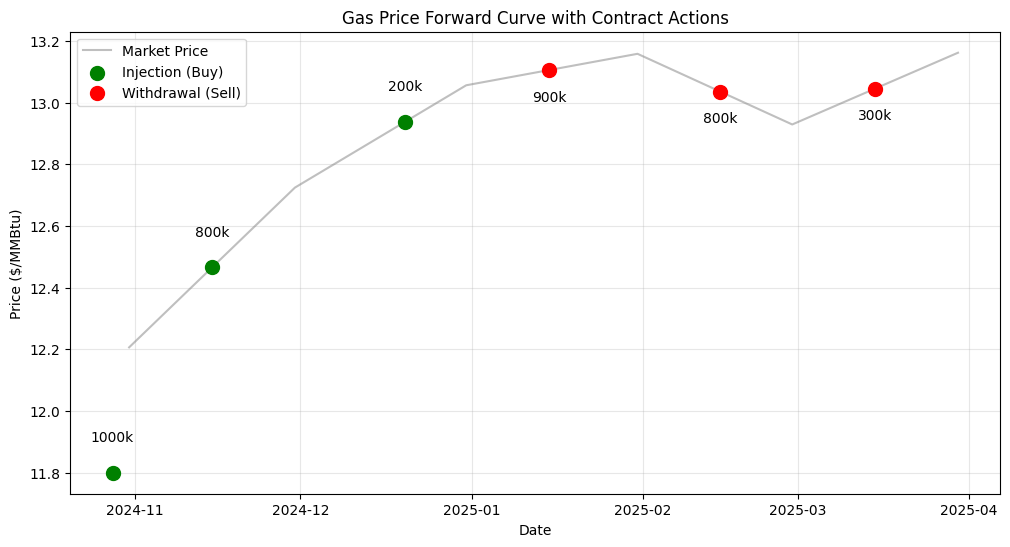

In [65]:
# Price Curve with Actions
plt.figure(figsize=(12, 6))

# Filter price curve to relevant range for better visibility
plot_start = df_res['Date'].min() - pd.Timedelta(days=15)
plot_end = df_res['Date'].max() + pd.Timedelta(days=15)
mask = (daily_forward_curve.index >= plot_start) & (daily_forward_curve.index <= plot_end)
subset_prices = daily_forward_curve.loc[mask]

plt.plot(subset_prices.index, subset_prices['Prices'], label='Market Price', color='gray', alpha=0.5)

# Add Actions
injections = df_res[df_res['Action'] == 'Injection']
withdrawals = df_res[df_res['Action'] == 'Withdrawal']

plt.scatter(injections['Date'], injections['Price'], color='green', s=100, label='Injection (Buy)', zorder=5)
plt.scatter(withdrawals['Date'], withdrawals['Price'], color='red', s=100, label='Withdrawal (Sell)', zorder=5)

for _, row in df_res.iterrows():
    offset = 0.1 if row['Action'] == 'Injection' else -0.1
    plt.annotate(f"{row['Executed_Volume']/1000:.0f}k", (row['Date'], row['Price'] + offset), ha='center')

plt.title('Gas Price Forward Curve with Contract Actions')
plt.xlabel('Date')
plt.ylabel('Price ($/MMBtu)')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('price_action_plot.png')

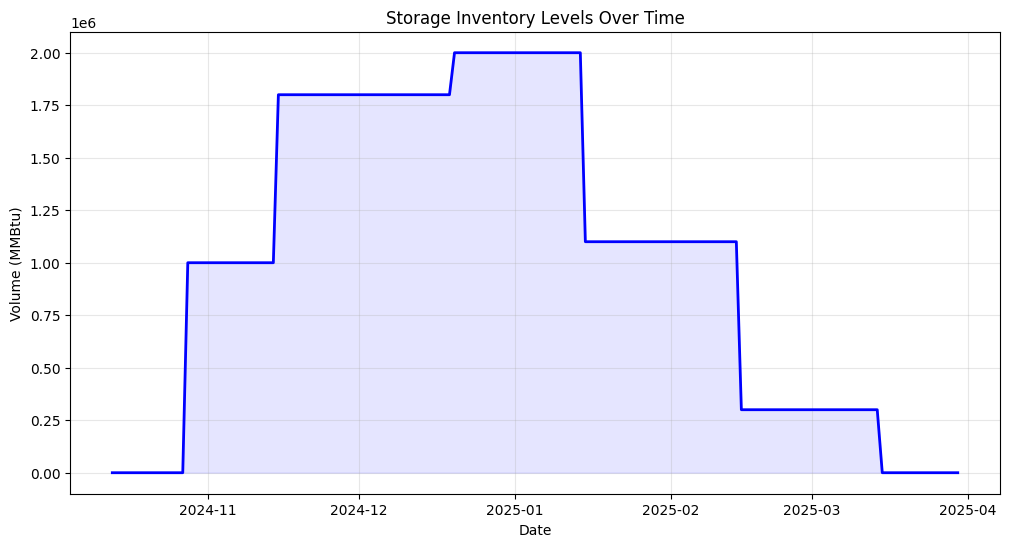

In [66]:
# Inventory Levels
plt.figure(figsize=(12, 6))
# Create step plot data
step_dates = [plot_start] + df_res['Date'].tolist() + [plot_end]
step_inventory = [0] + df_res['Inventory'].tolist() + [0] # Logic for step needs care

# Reindex to daily
daily_inventory = pd.Series(index=pd.date_range(start=plot_start, end=plot_end, freq='D'), data=0)
current_inv = 0
for _, row in df_res.iterrows():
    daily_inventory[row['Date']:] = row['Inventory']

plt.plot(daily_inventory.index, daily_inventory.values, color='blue', linewidth=2)
plt.fill_between(daily_inventory.index, daily_inventory.values, color='blue', alpha=0.1)
plt.title('Storage Inventory Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (MMBtu)')
plt.grid(True, alpha=0.3)
# plt.savefig('inventory_plot.png')

Visualizations generated.


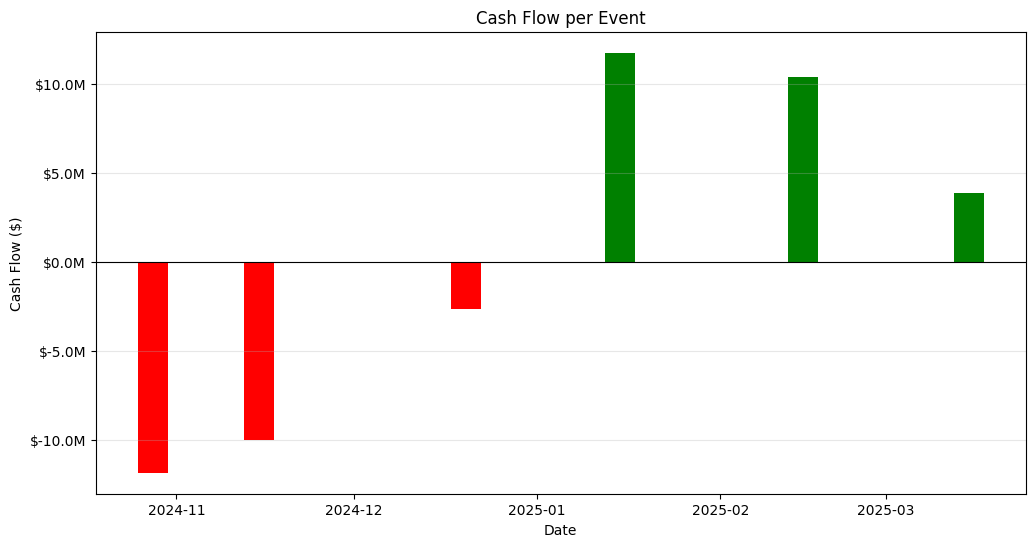

In [67]:
# CashFlow Waterfall/Bar
plt.figure(figsize=(12, 6))
colors = ['green' if x >= 0 else 'red' for x in df_res['Cash_Flow']]
plt.bar(df_res['Date'], df_res['Cash_Flow'], width=5, color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Cash Flow per Event')
plt.xlabel('Date')
plt.ylabel('Cash Flow ($)')
plt.grid(True, axis='y', alpha=0.3)

# Format y-axis to millions
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fM' % (x * 1e-6))
plt.gca().yaxis.set_major_formatter(formatter)

# plt.savefig('cash_flow_plot.png')

print("Visualizations generated.")